In [1]:
SRC_PATH = '' # SRC makes use of Relative Paths

In [2]:
# Imports Data Parsing tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
def load_headerless_data(file_path):
    """
        Load data from a headerless CSV file with two columns (X1 and X2)
    """
    # Read CSV without headers, assigning column names
    df = pd.read_csv(file_path, header=None, names=['X1', 'X2'])
    return df['X1'].values, df['X2'].values

print("Loading data...")
try:
    training_file = SRC_PATH + 'data_set_1.csv'
    prediction_file = SRC_PATH + 'data_set_2.csv'

    # load
    X1, X2 = load_headerless_data(training_file)

    # Load data 1
    X3, X4 = load_headerless_data(prediction_file)

    # Generate dummy Y values for training data (since we only need X1 and X2 for selection)
    Y = np.zeros(len(X1))  # Placeholder Y values

    # Normalize the data
    scaler = MinMaxScaler()
    X1 = scaler.fit_transform(X1.reshape(-1, 1)).ravel()
    X2 = scaler.fit_transform(X2.reshape(-1, 1)).ravel()
    X3 = scaler.fit_transform(X3.reshape(-1, 1)).ravel()
    X4 = scaler.fit_transform(X4.reshape(-1, 1)).ravel()
    Y = scaler.fit_transform(Y.reshape(-1, 1)).ravel()

    print(f"Loaded {len(X1)} data points successfully")
    print(f"Loaded {len(X3)} data points successfully")

except Exception as e:
    print(f"Error loading data: {e}")
    raise

Loading data...
Loaded 500000 data points successfully
Loaded 500000 data points successfully


# Class

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import Birch

class DataSelector:
    def __init__(self, X1, X2, target_samples=2500):
        """
        Initialize the DataSelector with input features and target number of samples
        """
        self.X = np.column_stack([X1, X2])
        self.target_samples = target_samples

    def UNI(self):
        """
        Selection Strategy #1: Uniform coverage of the operational space
        Uses K-means clustering to select points that provide uniform coverage
        """
        # Use K-means to find cluster centers
        kmeans = KMeans(n_clusters=self.target_samples, random_state=42)
        kmeans.fit(self.X)

        # For each cluster, find the point closest to its center
        selected_indices = []
        for center in kmeans.cluster_centers_:
            distances = np.linalg.norm(self.X - center, axis=1)
            selected_indices.append(np.argmin(distances))

        return np.array(selected_indices)

    def BIRCH(self):
      """
        Selection Strategy #3: Works better on large datasets v.s. k-means
      """
      # define the model
      birch_model = Birch(threshold=0.0005, n_clusters=self.target_samples)
      birch_model.fit(self.X)

      selected_indices = []
      for center in birch_model.subcluster_centers_:
            distances = np.linalg.norm(self.X - center, axis=1)
            selected_indices.append(np.argmin(distances))

      return np.array(selected_indices)

    def BIRCH_UNI(self):
        """
            Selection Strategy #4: Works better on large datasets v.s. k-means
        """
        # define the model
        birch_model = Birch(threshold=0.0005, n_clusters=self.target_samples*10)
        birch_model.fit(self.X)

        selected_indices = []
        for center in birch_model.subcluster_centers_:
            distances = np.linalg.norm(self.X - center, axis=1)
            selected_indices.append(np.argmin(distances))
            
        kmeans = KMeans(n_clusters=self.target_samples, random_state=42)
        kmeans.fit(self.X[np.array(selected_indices)])

        # For each cluster, find the point closest to its center
        selected_indices = []
        for center in kmeans.cluster_centers_:
            distances = np.linalg.norm(self.X - center, axis=1)
            selected_indices.append(np.argmin(distances))

        return np.array(selected_indices)

    def evaluate_coverage(self, selected_indices):
        """
            Evaluate the coverage of selected points
        """
        selected_points = self.X[selected_indices]

        coverage_metrics = {}

        min_distances = []
        for point in self.X:
            dist = np.min(np.linalg.norm(selected_points - point, axis=1))
            min_distances.append(dist)

        coverage_metrics['avg_min_distance'] = np.mean(min_distances)
        coverage_metrics['max_min_distance'] = np.max(min_distances)
        coverage_metrics['coverage_std'] = np.std(min_distances)

        return coverage_metrics

In [14]:
def visualize_selection(X1, X2, selected_indices, title, density=None):
    """
    Enhanced visualization function with density plot option
    """
    plt.figure(figsize=(12, 8))

    if density is not None:
        # Create density plot
        plt.scatter(X1, X2, c=density, cmap='viridis', alpha=0.5, s=1)
        plt.colorbar(label='Density')
    else:
        # Plot all points in light gray
        plt.scatter(X1, X2, c='lightgray', alpha=0.5, s=1, label='Original Data')

    # Plot selected points
    plt.scatter(X1[selected_indices], X2[selected_indices],
               c='red', s=20, label='Selected Points')

    plt.xlabel('Normalized Frequency (X1)')
    plt.ylabel('Normalized Power (X2)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
print("Initializing DataSelector...")
selector1 = DataSelector(X1, X2, target_samples=2500)
selector2 = DataSelector(X3, X4, target_samples=2500)

Initializing DataSelector...


# Cluster

Data 1
Performing uniform selection...
Creating visualizations...


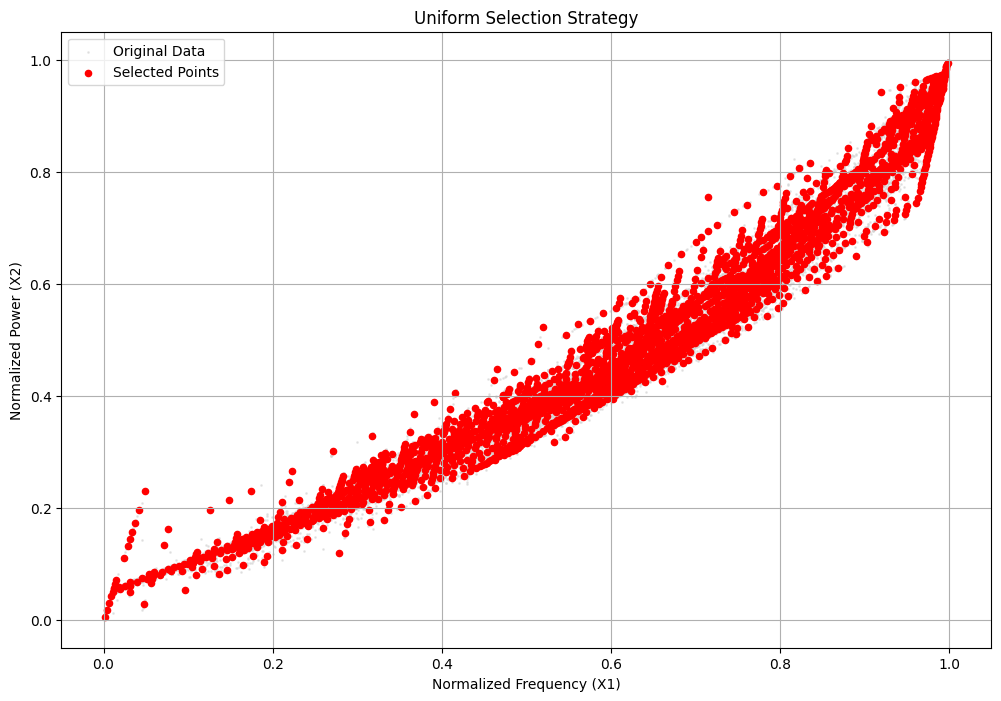


Uniform Selection Metrics:
avg_min_distance: 0.0008
max_min_distance: 0.0210
coverage_std: 0.0009

Saving selected data 1...
Data 2
Performing uniform selection...
Creating visualizations...


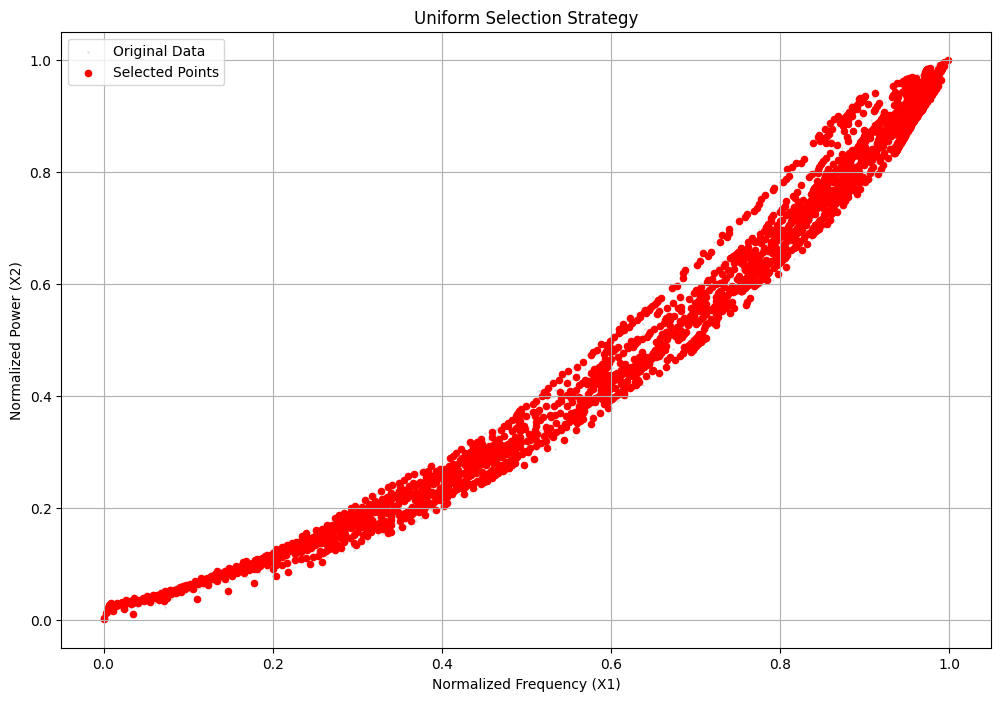


Uniform Selection Metrics:
avg_min_distance: 0.0004
max_min_distance: 0.0117
coverage_std: 0.0005

Saving selected data 2...


In [10]:
# Perform uniform selection
print("Data 1")
print("Performing uniform selection...")
uniform_indices = selector1.UNI()
uniform_metrics = selector1.evaluate_coverage(uniform_indices)

# Visualize results
print("Creating visualizations...")
visualize_selection(X1, X2, uniform_indices, "Uniform Selection Strategy")

# Print metrics
print("\nUniform Selection Metrics:")
for metric, value in uniform_metrics.items():
    print(f"{metric}: {value:.4f}")
    
print("\nSaving selected data 1...")
uniform_selected = pd.DataFrame({
    'X1': X1[uniform_indices],
    'X2': X2[uniform_indices],
    'Y': Y[uniform_indices]
})

uniform_selected.to_csv(SRC_PATH + 'uniform_selected_data_1.csv', index=False)

print("Data 2")
print("Performing uniform selection...")
uniform_indices = selector2.UNI()
uniform_metrics = selector2.evaluate_coverage(uniform_indices)

# Visualize results
print("Creating visualizations...")
visualize_selection(X3, X4, uniform_indices, "Uniform Selection Strategy")

# Print metrics
print("\nUniform Selection Metrics:")
for metric, value in uniform_metrics.items():
    print(f"{metric}: {value:.4f}")
    
print("\nSaving selected data 2...")
uniform_selected = pd.DataFrame({
    'X1': X3[uniform_indices],
    'X2': X4[uniform_indices],
    'Y': Y[uniform_indices]
})
uniform_selected.to_csv(SRC_PATH + 'uniform_selected_data_2.csv', index=False)

Data 1
Performing BIRCH selection...
Creating visualizations...


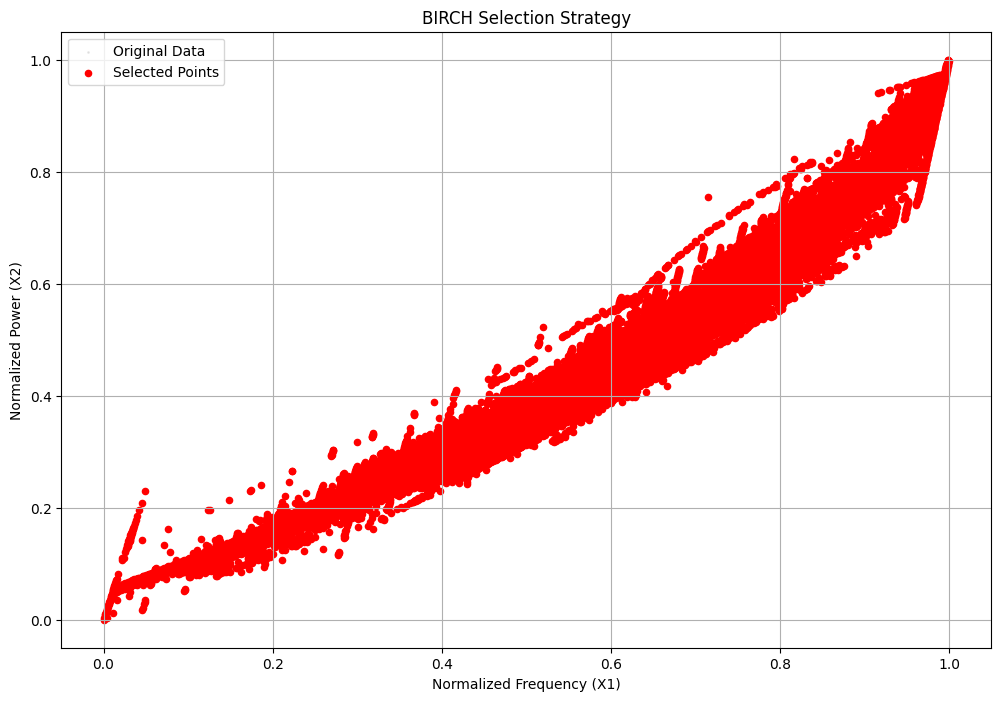


BIRCH Selection Metrics:
avg_min_distance: 0.0003
max_min_distance: 0.0033
coverage_std: 0.0002

Saving selected data 1...
Data 2
Performing BIRCH selection...
Creating visualizations...


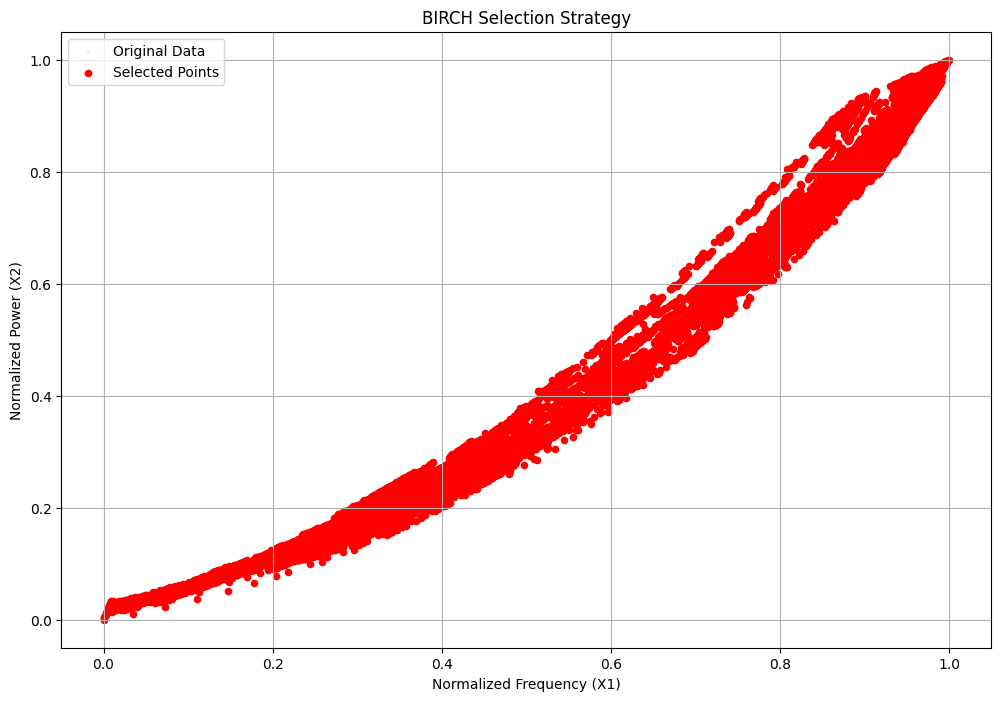


BIRCH Selection Metrics:
avg_min_distance: 0.0003
max_min_distance: 0.0023
coverage_std: 0.0002

Saving selected data 2...


In [11]:
# Perform BIRCH selection
print("Data 1")
print("Performing BIRCH selection...")
BIRCH_indices = selector1.BIRCH()
BIRCH_metrics = selector1.evaluate_coverage(BIRCH_indices)

# Visualize results
print("Creating visualizations...")
visualize_selection(X1, X2, BIRCH_indices, "BIRCH Selection Strategy")

# Print metrics
print("\nBIRCH Selection Metrics:")
for metric, value in BIRCH_metrics.items():
    print(f"{metric}: {value:.4f}")
    
print("\nSaving selected data 1...")
BIRCH_selected = pd.DataFrame({
    'X1': X1[BIRCH_indices],
    'X2': X2[BIRCH_indices],
    'Y': Y[BIRCH_indices]
})

BIRCH_selected.to_csv(SRC_PATH + 'BIRCH_selected_data_1.csv', index=False)

print("Data 2")
print("Performing BIRCH selection...")
BIRCH_indices = selector2.BIRCH()
BIRCH_metrics = selector2.evaluate_coverage(BIRCH_indices)

# Visualize results
print("Creating visualizations...")
visualize_selection(X3, X4, BIRCH_indices, "BIRCH Selection Strategy")

# Print metrics
print("\nBIRCH Selection Metrics:")
for metric, value in BIRCH_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nSaving selected data 2...")
BIRCH_selected = pd.DataFrame({
    'X1': X3[BIRCH_indices],
    'X2': X4[BIRCH_indices],
    'Y': Y[BIRCH_indices]
})
BIRCH_selected.to_csv(SRC_PATH + 'BIRCH_selected_data_2.csv', index=False)

Data 1
Performing BIRCH uniform selection...
Creating visualizations...


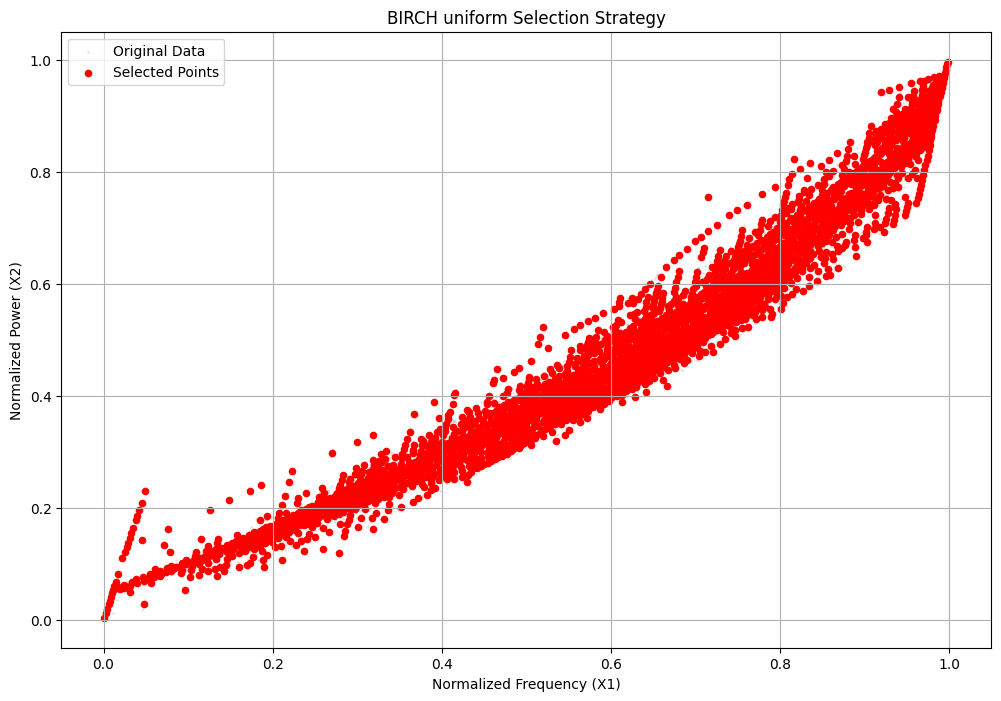


BIRCH uniform Selection Metrics:
avg_min_distance: 0.0019
max_min_distance: 0.0103
coverage_std: 0.0010

Saving selected data 1...
Data 2
Performing BIRCH uniform selection...


c:\Users\rgrap\Documents\Bs\.venv\Lib\site-packages\sklearn\cluster\_birch.py:725: ConvergenceWarning: Number of subclusters found (14768) by BIRCH is less than (25000). Decrease the threshold.
  warnings.warn(


Creating visualizations...


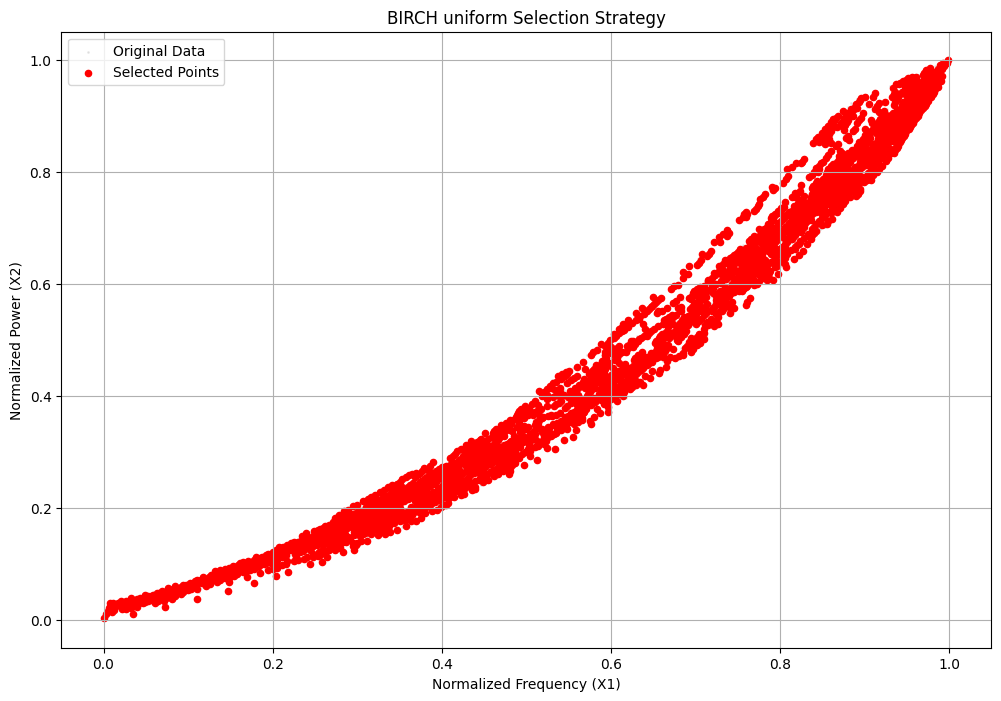


BIRCH uniform Selection Metrics:
avg_min_distance: 0.0013
max_min_distance: 0.0060
coverage_std: 0.0006

Saving selected data 2...


In [17]:
# Perform BIRCH uniform selection
print("Data 1")
print("Performing BIRCH uniform selection...")
BIRCH_indices = selector1.BIRCH_UNI()
BIRCH_metrics = selector1.evaluate_coverage(BIRCH_indices)

# Visualize results
print("Creating visualizations...")
visualize_selection(X1, X2, BIRCH_indices, "BIRCH uniform Selection Strategy")

# Print metrics
print("\nBIRCH uniform Selection Metrics:")
for metric, value in BIRCH_metrics.items():
    print(f"{metric}: {value:.4f}")
    
print("\nSaving selected data 1...")
BIRCH_selected = pd.DataFrame({
    'X1': X1[BIRCH_indices],
    'X2': X2[BIRCH_indices],
    'Y': Y[BIRCH_indices]
})

BIRCH_selected.to_csv(SRC_PATH + 'BIRCH_uniform_selected_data_1.csv', index=False)

print("Data 2")
print("Performing BIRCH uniform selection...")
BIRCH_indices = selector2.BIRCH_UNI()
BIRCH_metrics = selector2.evaluate_coverage(BIRCH_indices)

# Visualize results
print("Creating visualizations...")
visualize_selection(X3, X4, BIRCH_indices, "BIRCH uniform Selection Strategy")

# Print metrics
print("\nBIRCH uniform Selection Metrics:")
for metric, value in BIRCH_metrics.items():
    print(f"{metric}: {value:.4f}")
    
print("\nSaving selected data 2...")
BIRCH_selected = pd.DataFrame({
    'X1': X3[BIRCH_indices],
    'X2': X4[BIRCH_indices],
    'Y': Y[BIRCH_indices]
})
BIRCH_selected.to_csv(SRC_PATH + 'BIRCH_uniform_selected_data_2.csv', index=False)